In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import time
import copy
import re

from PIL import Image
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

from tqdm import tqdm


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertModel

In [2]:
# 완벽한 실험 재현성을 위한 랜덤제어
random_seed = 28
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060


# NLP and Vision Data

In [4]:
nlp_train_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/train.csv"
nlp_val_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/val.csv"
nlp_test_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/test.csv"

nlp_train_data = pd.read_csv(nlp_train_path)
nlp_val_data = pd.read_csv(nlp_val_path)
nlp_test_data = pd.read_csv(nlp_test_path)

X_train = nlp_train_data['productDisplayName']
y_train = nlp_train_data['label']

X_val = nlp_val_data['productDisplayName']
y_val = nlp_val_data['label']

X_test = nlp_test_data['productDisplayName']
y_test = nlp_test_data['label']

In [5]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [7]:
# Specify `MAX_LEN`
MAX_LEN = 30

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)


# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


C:\Users\ANDlab3\anaconda3\envs\GAN\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

image_path = "C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/"
image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
#                                              shuffle=False, num_workers=4)
#               for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

class_num = len(class_names)

In [9]:
val_img_temp = []
val_img_label_temp = []
for i, j in image_datasets['val']:
    val_img_temp.append(i)
    val_img_label_temp.append(j)

In [10]:
test_img_temp = []
test_img_label_temp = []
for i, j in image_datasets['test']:
    test_img_temp.append(i)
    test_img_label_temp.append(j)

In [11]:
train_img_temp = []
train_img_label_temp = []
for i, j in image_datasets['train']:
    train_img_temp.append(i)
    train_img_label_temp.append(j)

In [12]:
train_img = torch.stack(train_img_temp, 0)
train_img_label = torch.tensor(train_img_label_temp)

val_img = torch.stack(val_img_temp, 0)
val_img_label = torch.tensor(val_img_label_temp)

test_img = torch.stack(test_img_temp, 0)
test_img_label = torch.tensor(test_img_label_temp)

In [13]:
# # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_img, train_img_label)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels, val_img, val_img_label)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_img, test_img_label)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [18]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

6475
925
1850


# Vision Module

In [19]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

#Changing the number of outputs in the last layer to the number of different item types
model_ft.fc = nn.Linear(num_ftrs, 500)
pre_model= model_ft

In [20]:
class resnet_classifier(nn.Module):
    def __init__(self, pre_model):
        super(resnet_classifier, self).__init__()
    
        D_in, H, D_out = 1000, 500, 37
        self.resnet50 = pre_model
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(H, D_out)
        )
    
    def forward(self, image):
        outputs = self.resnet50(image)
        
        fc = self.classifier(outputs)
        
        return  fc

In [21]:
vision_module = resnet_classifier(pre_model)
vision_module.to(device)

resnet_classifier(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [22]:
IMG_SAVE_PATH = "C:/Users/ANDlab3/Desktop/paper/fashion-dataset/model/"
vision_module.load_state_dict(torch.load(IMG_SAVE_PATH+'model_fine_tuned_v2.pt'))

<All keys matched successfully>

In [23]:
vision_module

resnet_classifier(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [24]:
# 파라메타 번호 확인 하기
i = 0
for name, param in vision_module.named_parameters():
    
    print(i,name)
    i+= 1

0 resnet50.conv1.weight
1 resnet50.bn1.weight
2 resnet50.bn1.bias
3 resnet50.layer1.0.conv1.weight
4 resnet50.layer1.0.bn1.weight
5 resnet50.layer1.0.bn1.bias
6 resnet50.layer1.0.conv2.weight
7 resnet50.layer1.0.bn2.weight
8 resnet50.layer1.0.bn2.bias
9 resnet50.layer1.0.conv3.weight
10 resnet50.layer1.0.bn3.weight
11 resnet50.layer1.0.bn3.bias
12 resnet50.layer1.0.downsample.0.weight
13 resnet50.layer1.0.downsample.1.weight
14 resnet50.layer1.0.downsample.1.bias
15 resnet50.layer1.1.conv1.weight
16 resnet50.layer1.1.bn1.weight
17 resnet50.layer1.1.bn1.bias
18 resnet50.layer1.1.conv2.weight
19 resnet50.layer1.1.bn2.weight
20 resnet50.layer1.1.bn2.bias
21 resnet50.layer1.1.conv3.weight
22 resnet50.layer1.1.bn3.weight
23 resnet50.layer1.1.bn3.bias
24 resnet50.layer1.2.conv1.weight
25 resnet50.layer1.2.bn1.weight
26 resnet50.layer1.2.bn1.bias
27 resnet50.layer1.2.conv2.weight
28 resnet50.layer1.2.bn2.weight
29 resnet50.layer1.2.bn2.bias
30 resnet50.layer1.2.conv3.weight
31 resnet50.layer1

In [25]:
for i, (name, param) in enumerate(vision_module.named_parameters()):
    
    param.requires_grad = False
    if i == 158:
        print('end')

end


In [26]:
for p in vision_module.named_parameters():
    print(p)
    break

('resnet50.conv1.weight', Parameter containing:
tensor([[[[ 2.9832e-02,  2.7486e-02, -5.4940e-04,  ..., -1.5218e-02,
           -1.4472e-02, -4.5599e-02],
          [ 1.7806e-02,  1.4144e-02,  2.7383e-02,  ...,  2.5815e-02,
            3.9620e-03, -1.4788e-02],
          [ 3.1399e-02,  2.4234e-02,  2.0323e-02,  ...,  1.1810e-01,
            8.3817e-02,  7.4766e-02],
          ...,
          [ 8.8523e-03,  3.3135e-02, -2.9771e-03,  ..., -1.2287e-01,
           -6.9704e-02,  1.5388e-02],
          [ 2.0160e-02,  5.8223e-02,  7.5046e-02,  ...,  3.1977e-02,
           -2.5193e-02, -7.6963e-03],
          [-6.8655e-02, -2.2381e-02, -3.6866e-03,  ...,  5.2400e-02,
            4.0082e-02,  1.5968e-02]],

         [[ 2.5577e-03,  2.6901e-02,  3.7032e-02,  ...,  8.2444e-02,
            7.5451e-02,  1.6257e-02],
          [ 1.6055e-02,  3.5968e-02,  8.7621e-02,  ...,  1.9196e-01,
            1.7871e-01,  1.4971e-01],
          [-2.9695e-02, -6.6044e-02, -7.6467e-02,  ...,  1.4619e-01,
          

# NLP Module

In [27]:
%%time
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 500, 37

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.dense = nn.Sequential(
                nn.Linear(D_in, H),
        )
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

#         # Freeze the BERT model
#         if freeze_bert:
#             for param in self.bert.parameters():
#                 param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        
        dense = self.dense(last_hidden_state_cls)
        logits = self.classifier(dense)

        return logits

Wall time: 0 ns


In [28]:
NLP_module = BertClassifier()
NLP_module

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [29]:
NLP_SAVE_PATH = "C:/Users/ANDlab3/Desktop/NLP/model/"

In [30]:
NLP_module= NLP_module.to(device) # 모델 선언
NLP_module.load_state_dict(torch.load(NLP_SAVE_PATH+'bert_fine_tuned_v2.pt')) # 모델 파라메타 불러오기

<All keys matched successfully>

In [31]:
# 파라메타 번호 확인 하기
i = 0
for name, param in NLP_module.named_parameters():
    
    print(i,name)
    i+= 1

0 bert.embeddings.word_embeddings.weight
1 bert.embeddings.position_embeddings.weight
2 bert.embeddings.token_type_embeddings.weight
3 bert.embeddings.LayerNorm.weight
4 bert.embeddings.LayerNorm.bias
5 bert.encoder.layer.0.attention.self.query.weight
6 bert.encoder.layer.0.attention.self.query.bias
7 bert.encoder.layer.0.attention.self.key.weight
8 bert.encoder.layer.0.attention.self.key.bias
9 bert.encoder.layer.0.attention.self.value.weight
10 bert.encoder.layer.0.attention.self.value.bias
11 bert.encoder.layer.0.attention.output.dense.weight
12 bert.encoder.layer.0.attention.output.dense.bias
13 bert.encoder.layer.0.attention.output.LayerNorm.weight
14 bert.encoder.layer.0.attention.output.LayerNorm.bias
15 bert.encoder.layer.0.intermediate.dense.weight
16 bert.encoder.layer.0.intermediate.dense.bias
17 bert.encoder.layer.0.output.dense.weight
18 bert.encoder.layer.0.output.dense.bias
19 bert.encoder.layer.0.output.LayerNorm.weight
20 bert.encoder.layer.0.output.LayerNorm.bias
21 b

In [32]:
for i, (name, param) in enumerate(NLP_module.named_parameters()):
    
    param.requires_grad = False
    if i == 198:
        print('end')

end


In [33]:
for p in NLP_module.named_parameters():
    print(p)
    break

('bert.embeddings.word_embeddings.weight', Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0'))


# LanguageAndVisionConcat

In [34]:
class LanguageAndVisionConcat(nn.Module):    
    def __init__(
        self,
        nlp_module,
        vision_module,
        num_classes,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p):
        super(LanguageAndVisionConcat, self).__init__()
        self.nlp_module = nlp_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
                        in_features=(language_feature_dim + vision_feature_dim), 
                        out_features=fusion_output_size,
        )
        
        self.dropout = torch.nn.Dropout(dropout_p)
        
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        
   
    
    def forward(self, text, text2 , image):
        text_features = torch.nn.functional.relu(
            self.nlp_module(text, text2)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            ))
        logits = self.fc(fused)

        return logits

In [35]:
model = LanguageAndVisionConcat(
        nlp_module = NLP_module,
        vision_module = vision_module,
        num_classes = class_num,
        language_feature_dim = 37,
        vision_feature_dim = 37,
        fusion_output_size = 37,
        dropout_p = 0.2
)
model = model.to(device)
model

LanguageAndVisionConcat(
  (nlp_module): BertClassifier(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=Tru

# concat model train

In [36]:
criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Create the optimizer
optimizer = optim.AdamW(model.parameters(),
                  lr=5e-5,    # Default learning rate
                  eps=1e-8    # Default epsilon value
                  )

# # Total number of training steps
# total_steps = len(vision_train) * 2

# # Set up the learning rate scheduler
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=0, # Default value
#                                             num_training_steps=total_steps)

In [37]:
vision_train =  dataloaders['train']
vision_val =  dataloaders['val']
vision_test =  dataloaders['test']

nlp_train = train_dataloader
nlp_val = val_dataloader
nlp_test = test_dataloader

In [38]:
PATH ="C:/Users/ANDlab3/Desktop/VisionAndNLP/checkpoint_best3/"

train_loss = [] # 그래프를 그리기 위한 loss 저장용 리스트 
eval_loss = []
correct = 0
total = 0
best_acc = 0
best_epoch = 0

epoch = 200
# log_interval = 100

for epoch in range(epoch):
    time_epoch = time.time()
    
    model.train()
    running_loss = 0.0
    for data in train_dataloader:
        b_input_ids, b_attn_mask, b_labels, v_image, v_label = tuple(t.to(device) for t in data)

        optimizer.zero_grad()

        outputs = model(b_input_ids, b_attn_mask, v_image)
        loss = criterion(outputs, v_label) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        
        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
         # Update parameters and the learning rate
        optimizer.step() # 가중치 최적화
  #         scheduler.step() 
        running_loss += loss.item()
        
    train_loss.append(running_loss / len(vision_train))   
    
    
    model.eval()
    with torch.no_grad():
        eval_running_loss = 0.0
        for data in val_dataloader:
            b_input_ids, b_attn_mask, b_labels, v_image, v_label = tuple(t.to(device) for t in data)

            outputs = model(b_input_ids, b_attn_mask, v_image) 
            val_loss = criterion(outputs, v_label) 
            eval_running_loss += val_loss.item()

            _, pred = torch.max(outputs, 1)

            total += v_label.size(0)

            correct += (pred == v_label).sum().item()
            acc =  (100 * correct / total)
    
        eval_loss.append(eval_running_loss / len(vision_val)) 
        
        time_elapsed = time.time() - time_epoch
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), PATH+str(epoch+1)+'_best_model.pt')
            best_epoch = epoch+1
        
        print('[%d] Train loss: %.3f' %(epoch + 1, running_loss / len(vision_train))
     ,' val loss: %.3f' %(eval_running_loss / len(vision_val))
     ,'Acc:', round(acc,2) ,'time_elapsed:', round(time_elapsed),'second')
        
print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
print('Best epoch:', best_epoch, 'Best Acc:', round(best_acc, 2))

[1] Train loss: 3.527  val loss: 3.326 Acc: 17.95 time_elapsed: 30 second
[2] Train loss: 3.176  val loss: 2.952 Acc: 29.68 time_elapsed: 27 second
[3] Train loss: 2.811  val loss: 2.552 Acc: 43.64 time_elapsed: 26 second
[4] Train loss: 2.434  val loss: 2.138 Acc: 53.49 time_elapsed: 26 second
[5] Train loss: 2.044  val loss: 1.730 Acc: 60.02 time_elapsed: 26 second
[6] Train loss: 1.656  val loss: 1.338 Acc: 65.42 time_elapsed: 27 second
[7] Train loss: 1.312  val loss: 1.005 Acc: 69.62 time_elapsed: 26 second
[8] Train loss: 1.021  val loss: 0.739 Acc: 72.89 time_elapsed: 26 second
[9] Train loss: 0.785  val loss: 0.546 Acc: 75.45 time_elapsed: 26 second
[10] Train loss: 0.592  val loss: 0.400 Acc: 77.5 time_elapsed: 26 second
[11] Train loss: 0.465  val loss: 0.313 Acc: 79.18 time_elapsed: 27 second
[12] Train loss: 0.368  val loss: 0.253 Acc: 80.59 time_elapsed: 26 second
[13] Train loss: 0.303  val loss: 0.205 Acc: 81.77 time_elapsed: 26 second
[14] Train loss: 0.255  val loss: 0

[111] Train loss: 0.036  val loss: 0.069 Acc: 95.83 time_elapsed: 26 second
[112] Train loss: 0.041  val loss: 0.068 Acc: 95.84 time_elapsed: 26 second
[113] Train loss: 0.039  val loss: 0.070 Acc: 95.86 time_elapsed: 26 second
[114] Train loss: 0.039  val loss: 0.070 Acc: 95.88 time_elapsed: 26 second
[115] Train loss: 0.041  val loss: 0.070 Acc: 95.9 time_elapsed: 26 second
[116] Train loss: 0.041  val loss: 0.070 Acc: 95.91 time_elapsed: 27 second
[117] Train loss: 0.038  val loss: 0.072 Acc: 95.93 time_elapsed: 26 second
[118] Train loss: 0.034  val loss: 0.070 Acc: 95.95 time_elapsed: 26 second
[119] Train loss: 0.038  val loss: 0.070 Acc: 95.96 time_elapsed: 26 second
[120] Train loss: 0.039  val loss: 0.070 Acc: 95.98 time_elapsed: 26 second
[121] Train loss: 0.038  val loss: 0.069 Acc: 96.0 time_elapsed: 26 second
[122] Train loss: 0.038  val loss: 0.070 Acc: 96.01 time_elapsed: 26 second
[123] Train loss: 0.041  val loss: 0.072 Acc: 96.03 time_elapsed: 26 second
[124] Train lo

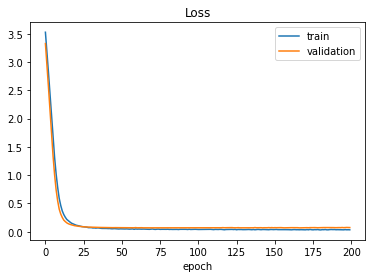

In [39]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

# 베스트 모델 불러오기

In [ ]:
# best_model = model.to(device) # 모델 선언
# best_model.load_state_dict(torch.load(PATH+str(best_epoch)+'_best_model.pt'))

In [40]:
test_total = 0
test_correct = 0

true = []
test_pred = []
# nlp_true = []

model.eval()
with torch.no_grad():
    for data in val_dataloader:
        b_input_ids, b_attn_mask, b_labels, v_image, v_label = tuple(t.to(device) for t in data)

        outputs = model(b_input_ids, b_attn_mask, v_image) 

        _, pred = torch.max(outputs, 1)
        
#         test = torch.argmax(outputs, 1)
        
        test_total += v_label.size(0)
        test_correct += (pred == v_label).sum().item()
        
        true += v_label.cpu().numpy().tolist()
#         nlp_true += b_labels.cpu().numpy().tolist()
        test_pred += pred.cpu().numpy().tolist()        

print('Accuracy of the network on the val data:', round((100 * test_correct / test_total),2),'%')

Accuracy of the network on the val data: 97.73 %


In [41]:
# Classification Report 저장
CL_REPORT_FILE = "./cl_report.csv"

cl_report = classification_report(true, test_pred, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
# cl_report_df.to_csv(CL_REPORT_FILE)
print(cl_report_df)

              precision  recall  f1-score  support
0                 1.000   0.920     0.958   25.000
1                 1.000   1.000     1.000   25.000
2                 0.962   1.000     0.980   25.000
3                 1.000   1.000     1.000   25.000
4                 1.000   1.000     1.000   25.000
5                 0.955   0.840     0.894   25.000
6                 1.000   0.960     0.980   25.000
7                 1.000   0.960     0.980   25.000
8                 1.000   1.000     1.000   25.000
9                 1.000   1.000     1.000   25.000
10                0.759   0.880     0.815   25.000
11                1.000   1.000     1.000   25.000
12                0.926   1.000     0.962   25.000
13                0.893   1.000     0.943   25.000
14                0.950   0.760     0.844   25.000
15                1.000   1.000     1.000   25.000
16                1.000   1.000     1.000   25.000
17                0.962   1.000     0.980   25.000
18                1.000   1.000